This tutorial demonstrates how to read in a particle stack in `cryojax`. The particle stack read here is given in [RELION](https://relion.readthedocs.io/en/release-5.0/) STAR file format.

After reading the particle stack, it is demonstrated how to compute a *power spectrum* using `cryojax`.

In [1]:
# JAX imports
import equinox as eqx
import jax.numpy as jnp

In [ ]:
# Plotting imports and functions
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_image(image, fig, ax, cmap="gray", label=None, **kwargs):
    im = ax.imshow(image, cmap=cmap, origin="lower", **kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    if label is not None:
        ax.set(title=label)
    return fig, ax

: 

In [4]:
# CryoJAX imports
from cryojax.data import RelionParticleDataset, RelionParticleMetadata

: 

First, we will read in the RELION particle stack using the `cryojax` particle stack loader `RelionParticleDataset`.

!!! info "What is a `RelionParticleDataset`?"

    CryoJAX implements an abstraction an a dataset in RELION, called a `RelionParticleDataset`. This object takes in a
    RELION STAR file for a particle stack. Upon accessing an image in the particle stack, a `RelionParticleStack`
    is returned. Specifically, the `RelionParticleStack` stores the image(s) in the image stack, as well as the metadata, represented as a `RelionParticleParameters` container,
    in the STAR file. The metadata is instantiates compatible `cryojax` objects. For example, the `RelionParticleParameters`
    stores a `cryojax` models for the contrast transfer function (the `ContrastTransferFunction` class) and the pose (the `EulerAnglePose` class).

    More generally, a `RelionParticleDataset` is an `AbstractDataset`, which is complemented by the abstraction of a particle stack: the `AbstractParticleStack`.
    These abstract interfaces are part of the `cryojax` public API!

In [5]:
# Read in the dataset and plot an image
particle_metadata = RelionParticleMetadata(
    path_to_starfile="./data/ribosome_4ug0_particles.star",
    path_to_relion_project="./",
)
particle_dataset = RelionParticleDataset(particle_metadata)
# ... get the zeroth entry in the STAR file
relion_particle = particle_dataset[0]
print(relion_particle)

RelionParticleStack(
  parameters=RelionParticleParameters(
    instrument_config=InstrumentConfig(
      shape=(100, 100),
      pixel_size=f32[],
      voltage_in_kilovolts=weak_f32[],
      electrons_per_angstrom_squared=weak_f32[],
      padded_shape=(100, 100),
      pad_mode='constant'
    ),
    pose=EulerAnglePose(
      offset_x_in_angstroms=weak_f32[],
      offset_y_in_angstroms=weak_f32[],
      view_phi=weak_f32[],
      view_theta=weak_f32[],
      view_psi=weak_f32[]
    ),
    transfer_theory=ContrastTransferTheory(
      ctf=ContrastTransferFunction(
        defocus_in_angstroms=f32[],
        astigmatism_in_angstroms=f32[],
        astigmatism_angle=f32[],
        spherical_aberration_in_mm=f32[],
        amplitude_contrast_ratio=f32[],
        phase_shift=f32[]
      ),
      envelope=Constant(value=weak_f32[])
    )
  ),
  image_stack=f32[100,100]
)


: 

Upon inspecting the zeroth element of the `RelionParticleDataset`, we see that a `RelionParticleStack` is returned. We can access a particular image by accessing the `RelionParticleStack.image_stack`. Let's normalize this image, plot it, and make sure the mean and standard deviation are zero and one, respectively.

Image mean: -4.9591065e-09 Image standard deviation: 0.99999994


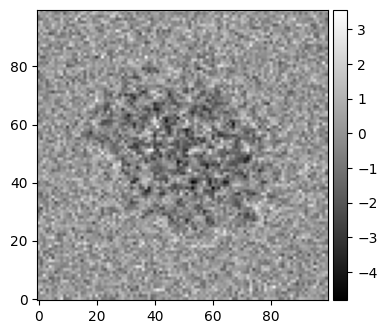

: 

In [ ]:
# Get an image, normalize, and plot it
from cryojax.image import normalize_image


fig, ax = plt.subplots(figsize=(4, 4))
observed_image = normalize_image(relion_particle.image_stack, is_real=True)
plot_image(observed_image, fig, ax)
print(
    "Image mean:",
    observed_image.mean(),
    "Image standard deviation:",
    observed_image.std(),
)

This particular image happens to be simulated with `cryojax` from the structure of the human 80S ribosome (PDB id 4gu0). In order to simulate the image, a scattering potential was computed and written to a voxel grid using the [`cisTEM`](https://github.com/timothygrant80/cisTEM) simulation tool.

We can also use fancy indexing to access multiple particles at once.

In [ ]:
# Access multiple images in the stack
relion_particles = particle_dataset[0:3]
print(relion_particles.image_stack.shape)

TypeError: 'bool' object is not subscriptable

: 

Now, we see that the `image_stack` attribute has a leading dimension for each image. We can also inspect the metadata read from the STAR file by printing the `ContrastTransferFunction`.

In [7]:
# Inspect the CTF
eqx.tree_pprint(relion_particles.parameters.transfer_theory.ctf, short_arrays=False)

ContrastTransferFunction(
  defocus_in_angstroms=Array([10025.484, 10025.484, 10025.484], dtype=float32),
  astigmatism_in_angstroms=Array([50.970703, 50.970703, 50.970703], dtype=float32),
  astigmatism_angle=Array([-54.58706, -54.58706, -54.58706], dtype=float32),
  spherical_aberration_in_mm=Array(2.7, dtype=float32),
  amplitude_contrast_ratio=Array(0.1, dtype=float32),
  phase_shift=Array([0., 0., 0.], dtype=float32)
)


: 

: 

Notice that not all attributes of the `ContrastTransferFunction` have a leading dimension. For those familiar with RELION STAR format, only the `ContrastTransferFunction` parameters stored on a per-particle basis have a leading dimension! Parameters stored in the opticsGroup do not have a leading dimension.

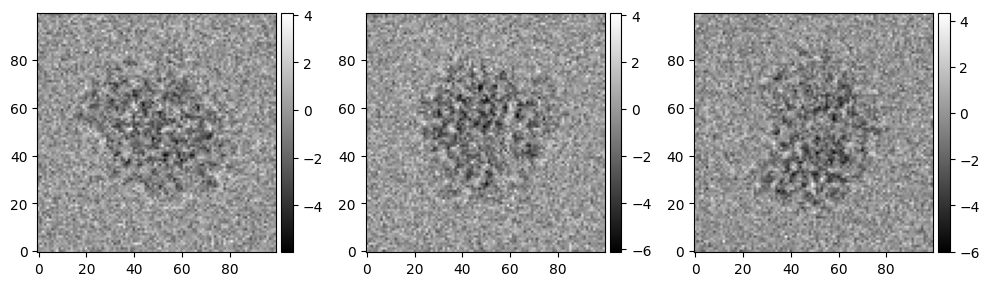

: 

: 

In [8]:
# Plot multiple images from the particle stack
fig, axes = plt.subplots(figsize=(10, 5), ncols=3)
[plot_image(relion_particles.image_stack[idx], fig, axes[idx]) for idx in range(3)]
plt.tight_layout()

Computing the power spectrum of an image is a common analysis tool in cryo-EM. This can be done in `cryojax`!

First, we simply have to compute our image in fourier space and a grid of wave vector magnitudes.

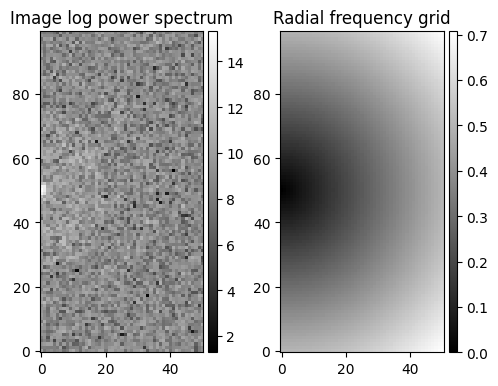

: 

: 

In [9]:
from cryojax.image import rfftn


# Get the particle
relion_particle = particle_dataset[0]
# ... and the image in fourier space
fourier_image = rfftn(relion_particle.image_stack)
# ... and the cartesian coordinate system
pixel_size = relion_particle.parameters.instrument_config.pixel_size
frequency_grid_in_angstroms = (
    relion_particle.parameters.instrument_config.frequency_grid_in_angstroms
)
# ... now, compute a radial coordinate system
radial_frequency_grid_in_angstroms = jnp.linalg.norm(frequency_grid_in_angstroms, axis=-1)
# ... plot the image in fourier space and the radial frequency grid
fig, axes = plt.subplots(figsize=(5, 4), ncols=2)
plot_image(
    jnp.log(jnp.abs(jnp.fft.fftshift(fourier_image, axes=(0,))) ** 2),
    fig,
    axes[0],
    label="Image log power spectrum",
)
plot_image(
    jnp.fft.fftshift(radial_frequency_grid_in_angstroms * pixel_size, axes=(0,)),
    fig,
    axes[1],
    label="Radial frequency grid",
)
plt.tight_layout()

We are now ready to compute and plot the radially averaged power spectrum profile! This simply bins the squared fourier amplitudes according to the `radial_frequency_grid`.

[Text(0.5, 0, 'frequency magnitude $[\\AA^{-1}]$'),
 Text(0, 0.5, 'radially averaged power spectrum'),
 None]

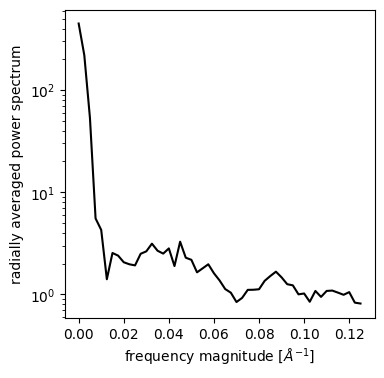

: 

: 

In [10]:
from cryojax.image import compute_radially_averaged_powerspectrum


fig, ax = plt.subplots(figsize=(4, 4))
n_pixels = relion_particle.parameters.instrument_config.n_pixels
spectrum, frequencies = compute_radially_averaged_powerspectrum(
    fourier_image,
    radial_frequency_grid_in_angstroms,
    pixel_size,
    maximum_frequency=1 / (2 * pixel_size),
)
ax.plot(frequencies, spectrum / n_pixels, color="k")
ax.set(
    xlabel="frequency magnitude $[\AA^{-1}]$",
    ylabel="radially averaged power spectrum",
    yscale="log",
)

Here, we see that the Thon rings in our power spectrum are faint since the pixel since of our images is $4 \ \AA$.